In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from IPython.display import display
import theano.tensor as tt
import pymc3 as pm

            cases
2020-01-01      0
2020-01-02      1
2020-01-03      0
2020-01-04      0
2020-01-05      0
...           ...
2021-09-06   6822
2021-09-07  14861
2021-09-08  13809
2021-09-09  11894
2021-09-10  10565

[619 rows x 1 columns]


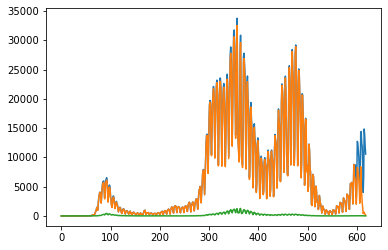

In [2]:
data = pd.read_csv("./../Data/kaggle/covid_de.csv", dtype="str").iloc[:989533]
date_data_begin = datetime.date(2020,1,1)
date_data_end = datetime.date(2021,9,10)

data = data.dropna()
data = data.astype({"cases":"int"})
cases = data.groupby("date")['cases'].sum().reset_index()
idx = pd.period_range(date_data_begin, date_data_end)
groupby_day = cases.groupby(pd.PeriodIndex(data=cases.date, freq='D'))
cases = groupby_day.sum()
cases = cases.reindex(idx, fill_value=0)
cases = np.array(cases["cases"])
 

data = data.astype({"deaths":"int"})
deaths = data.groupby("date")['deaths'].sum().reset_index()
idx = pd.period_range(date_data_begin, date_data_end)
groupby_day = deaths.groupby(pd.PeriodIndex(data=deaths.date, freq='D'))
deaths = groupby_day.sum()
deaths = deaths.reindex(idx, fill_value=0)
deaths = np.array(deaths["deaths"])

data = data.astype({"recovered":"int"})
recovered = data.groupby("date")['recovered'].sum().reset_index()
idx = pd.period_range(date_data_begin, date_data_end)
groupby_day = recovered.groupby(pd.PeriodIndex(data=recovered.date, freq='D'))
recovered = groupby_day.sum()
recovered = recovered.reindex(idx, fill_value=0)
recovered = np.array(recovered["recovered"])

cases_obs, recovered_obs, dead_obs = cases, recovered, deaths

data_germany = np.stack([cases_obs, recovered_obs, dead_obs]).T

T = data_germany.shape[0]
N_germany = 83e6
mean_g = np.mean(data_germany, axis=0)
std_g = np.std(data_germany, axis=0)

plt.plot(data_germany)

False


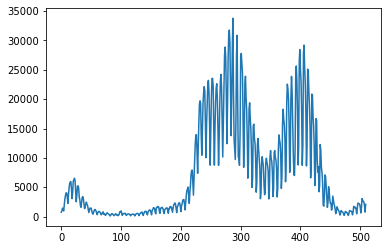

In [11]:
c_pt = data_germany[70:580,0]
n = c_pt.shape[0]
X = np.arange(n).reshape(-1,1)
plt.plot(X, c_pt)

In [ ]:
X_ = np.linspace(0, c_pt.shape[0],300)[:, None]

with pm.Model() as model_prior:
    l_t = pm.InverseGamma('l_t', 4, c_pt.shape[0]/4)
    l_p = pm.InverseGamma('l_p', 4, c_pt.shape[0])
    
    c = pm.Normal('c', 0, 0.05)

    η_trend = pm.HalfNormal('η_trend',0.1)
    η_ts = pm.HalfNormal('η_ts', 0.01)
    η_per = pm.HalfNormal('η_per', 0.2)
    σ  = pm.HalfNormal("σ",  sigma=0.02)

    cov = (η_trend**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t)
           + η_ts**2 * pm.gp.cov.Linear(input_dim=1, c=c)
           + η_per**2 * pm.gp.cov.Periodic(1, period=7, ls=l_p)
            + pm.gp.cov.WhiteNoise(σ))
    
    gp = pm.gp.Latent(mean_func = pm.gp.mean.Zero(), cov_func = cov)
    
    f = gp.prior("f", X=X_)
    f_ = pm.Deterministic('f_', tt.exp(f))
    
    prior_checks = pm.sample_prior_predictive(samples=1000)

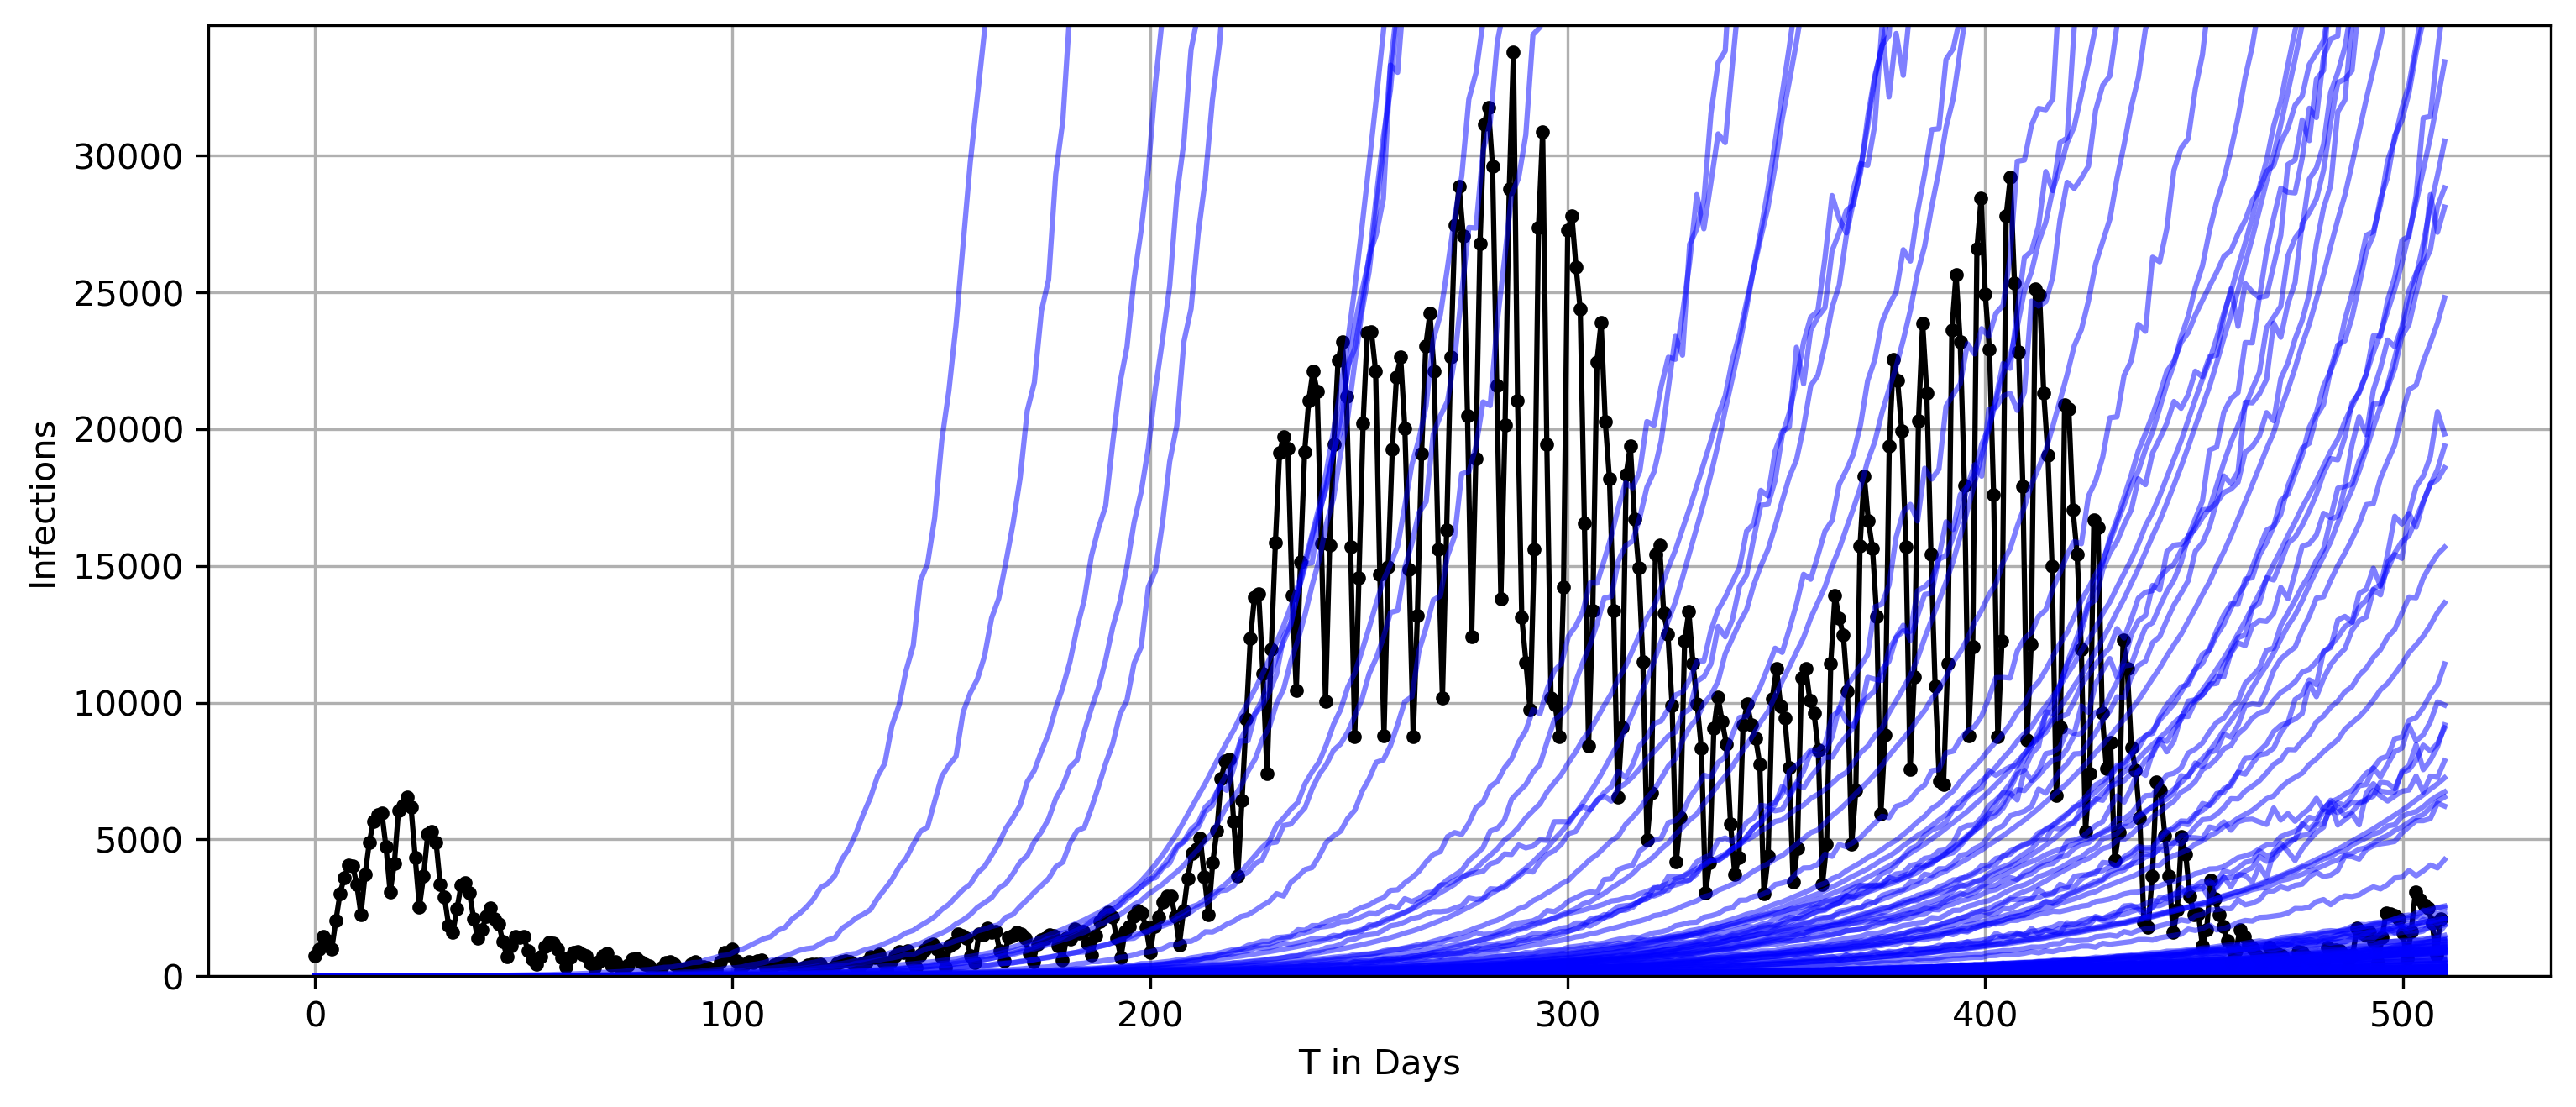

In [67]:
plt.figure(figsize=(12,5), dpi=300)
plt.plot(c_pt, ".-", color='black')
plt.plot(X_, prior_checks['f_'].T, color='b', alpha=0.5)
plt.ylim(0, c_pt.max()+1000)
plt.grid()
plt.ylabel("Infections")
plt.xlabel("T in Days")
plt.savefig("gp_infections_priors.png")

In [14]:
with pm.Model() as model:

    l_t = pm.InverseGamma('l_t', 4, c_pt.shape[0]/4)
    l_p = pm.InverseGamma('l_p', 4, c_pt.shape[0])
    c = pm.Normal('c', 0, 0.05)

    η_trend = pm.HalfNormal('η_trend',0.1)
    η_ts = pm.HalfNormal('η_ts', 0.01)
    η_per = pm.HalfNormal('η_per', 0.2)
    σ  = pm.HalfNormal("σ",  sigma=0.02)
    
    cov = (η_trend**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t)
           + η_ts**2 * pm.gp.cov.Linear(input_dim=1, c=c)
           + η_per**2 * pm.gp.cov.Periodic(1, period=7, ls=l_p)
            + pm.gp.cov.WhiteNoise(σ))
    
    gp = pm.gp.Latent(mean_func = pm.gp.mean.Zero(), cov_func = cov)
    f = gp.prior('f', X=X, reparameterize=True)

    y_pred = pm.Poisson('y_pred', mu=tt.exp(f), observed=c_pt)
    mp = pm.find_MAP(maxeval=20000, progressbar = True)

In [18]:
n_new = n+50
X_new = np.arange(c_pt.shape[0]+50).reshape(-1,1)
with pm.Model() as model:
    f_n = gp.conditional('f_n', Xnew=X_new)

    y_pred_new = pm.Poisson("y_pred_new", 
                            mu=tt.exp(f_n), 
                            shape=X_new.shape[0])

    pred_samples = pm.sample_posterior_predictive([mp], 
                                              var_names=["y_pred_new"],
                                              samples=200,
                                              progressbar = False)
    
from pymc3.gp.util import plot_gp_dist

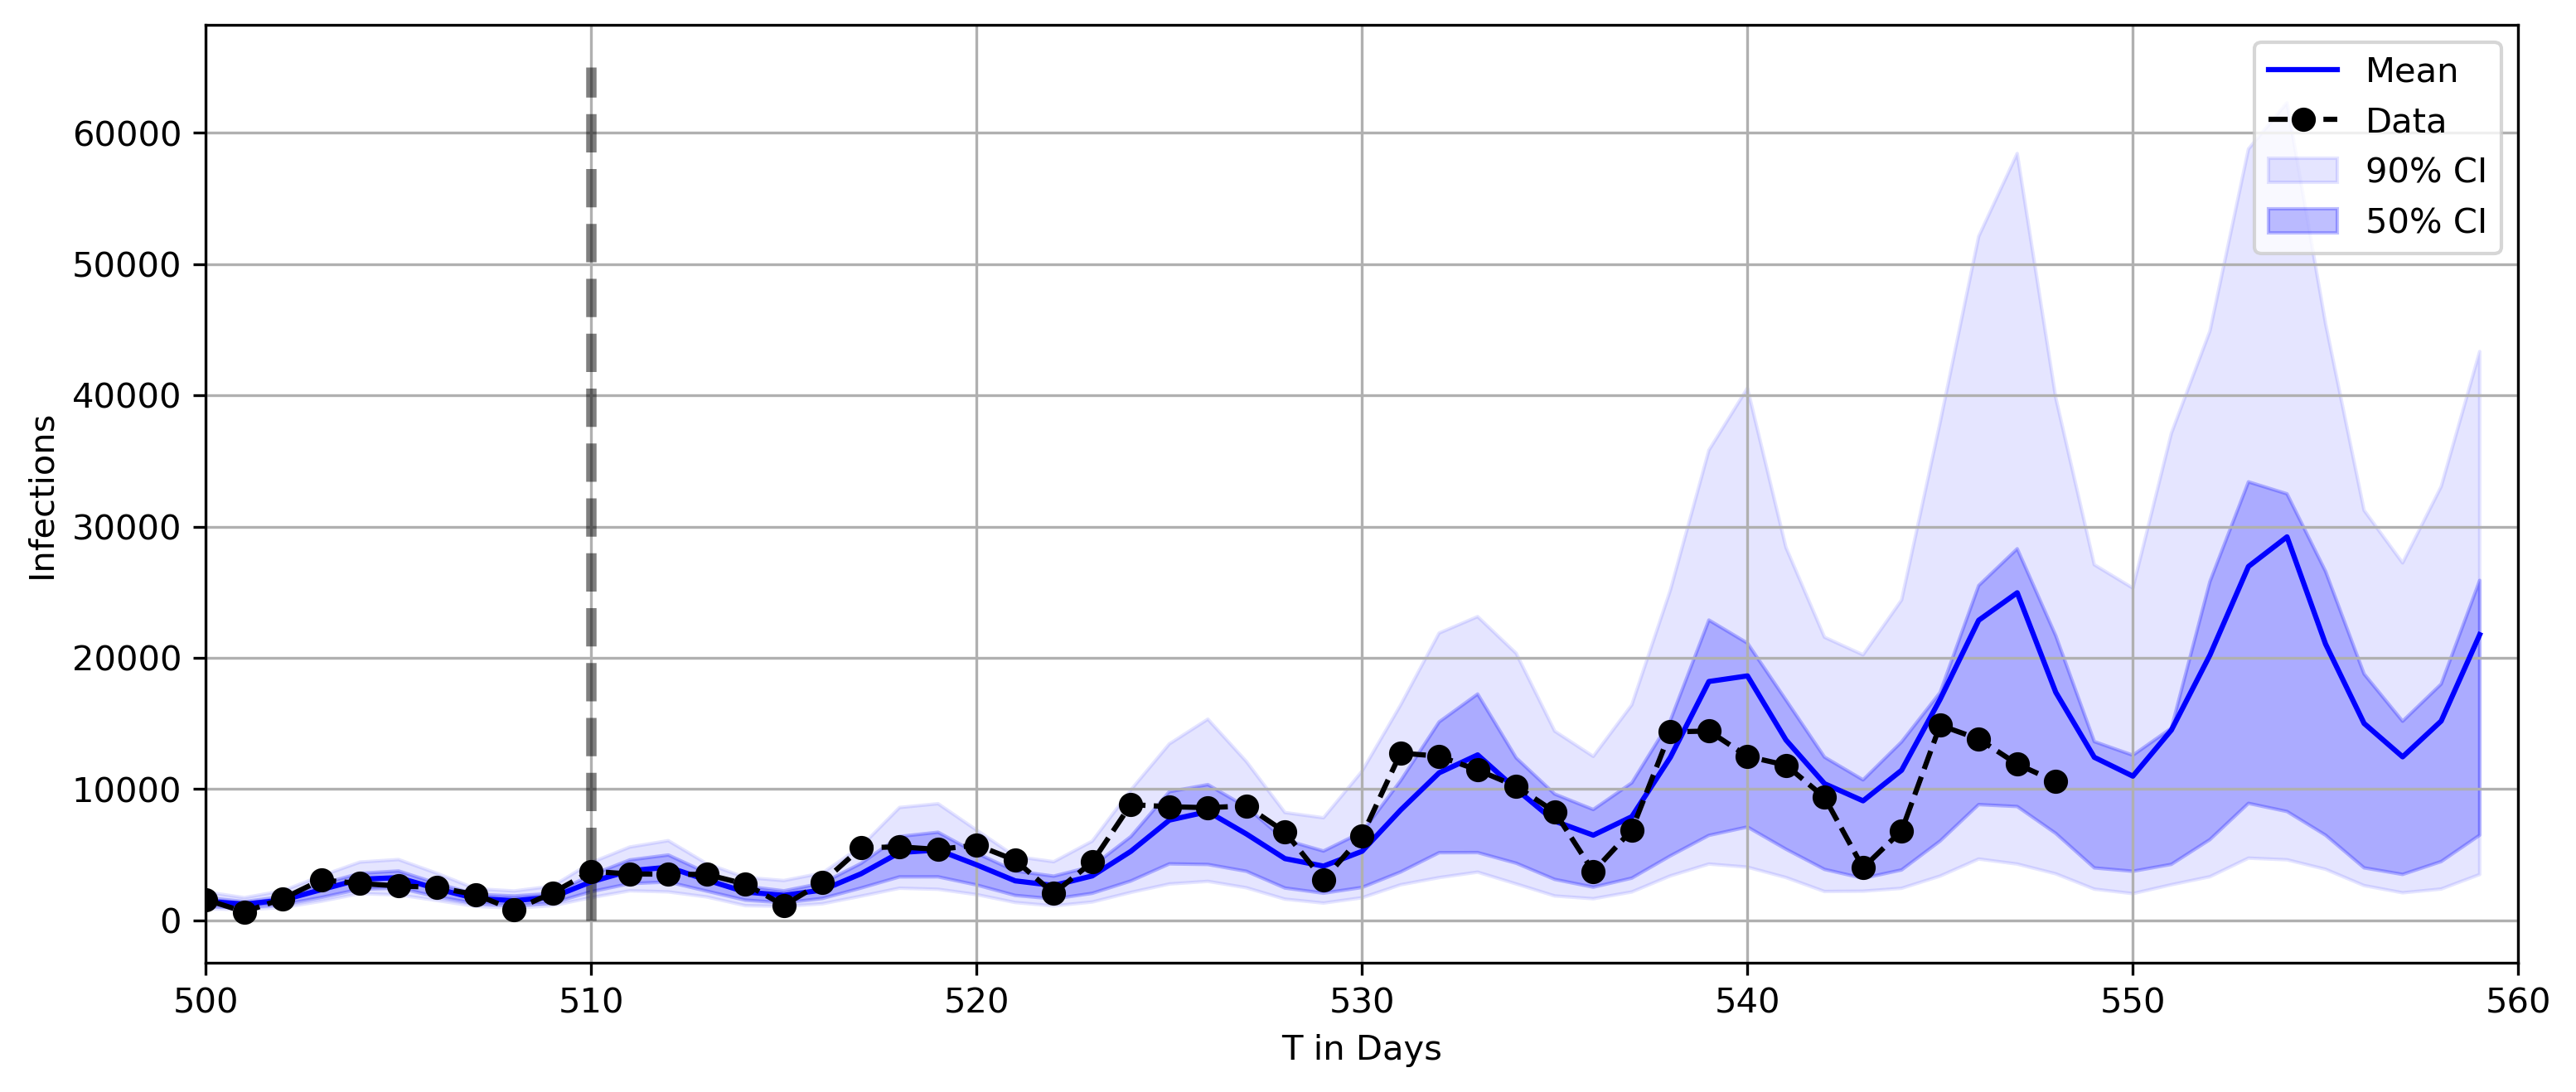

In [68]:
fig = plt.figure(figsize=(12,5), dpi=300)
plt.fill_between(np.arange(0, n_new), np.percentile(pred_samples['y_pred_new'], axis=0, q=[10]).ravel()[:],
                 np.percentile(pred_samples['y_pred_new'], axis=0, q=[90]).ravel()[:], alpha = 0.1, color='b', label='90% CI');
plt.fill_between(np.arange(0, n_new), np.percentile(pred_samples['y_pred_new'], axis=0, q=[25]).ravel()[:],
                 np.percentile(pred_samples['y_pred_new'], axis=0, q=[75]).ravel()[:], alpha = 0.25, color='b', label='50% CI');
plt.plot(np.arange(0, n_new), np.mean(pred_samples['y_pred_new'], axis=0)[:], color="blue", label='Mean')
plt.plot(np.arange(T-70),data_germany[70:,0], "o--", color="black", label="Data")
plt.legend()
plt.grid()
plt.vlines(510, 0, 65000, linewidth=3, color="black", alpha=0.5, linestyle="--")
plt.ylabel("Infections")
plt.xlabel("T in Days")
plt.xlim(500,560)
plt.savefig("gp_infections_close.png")

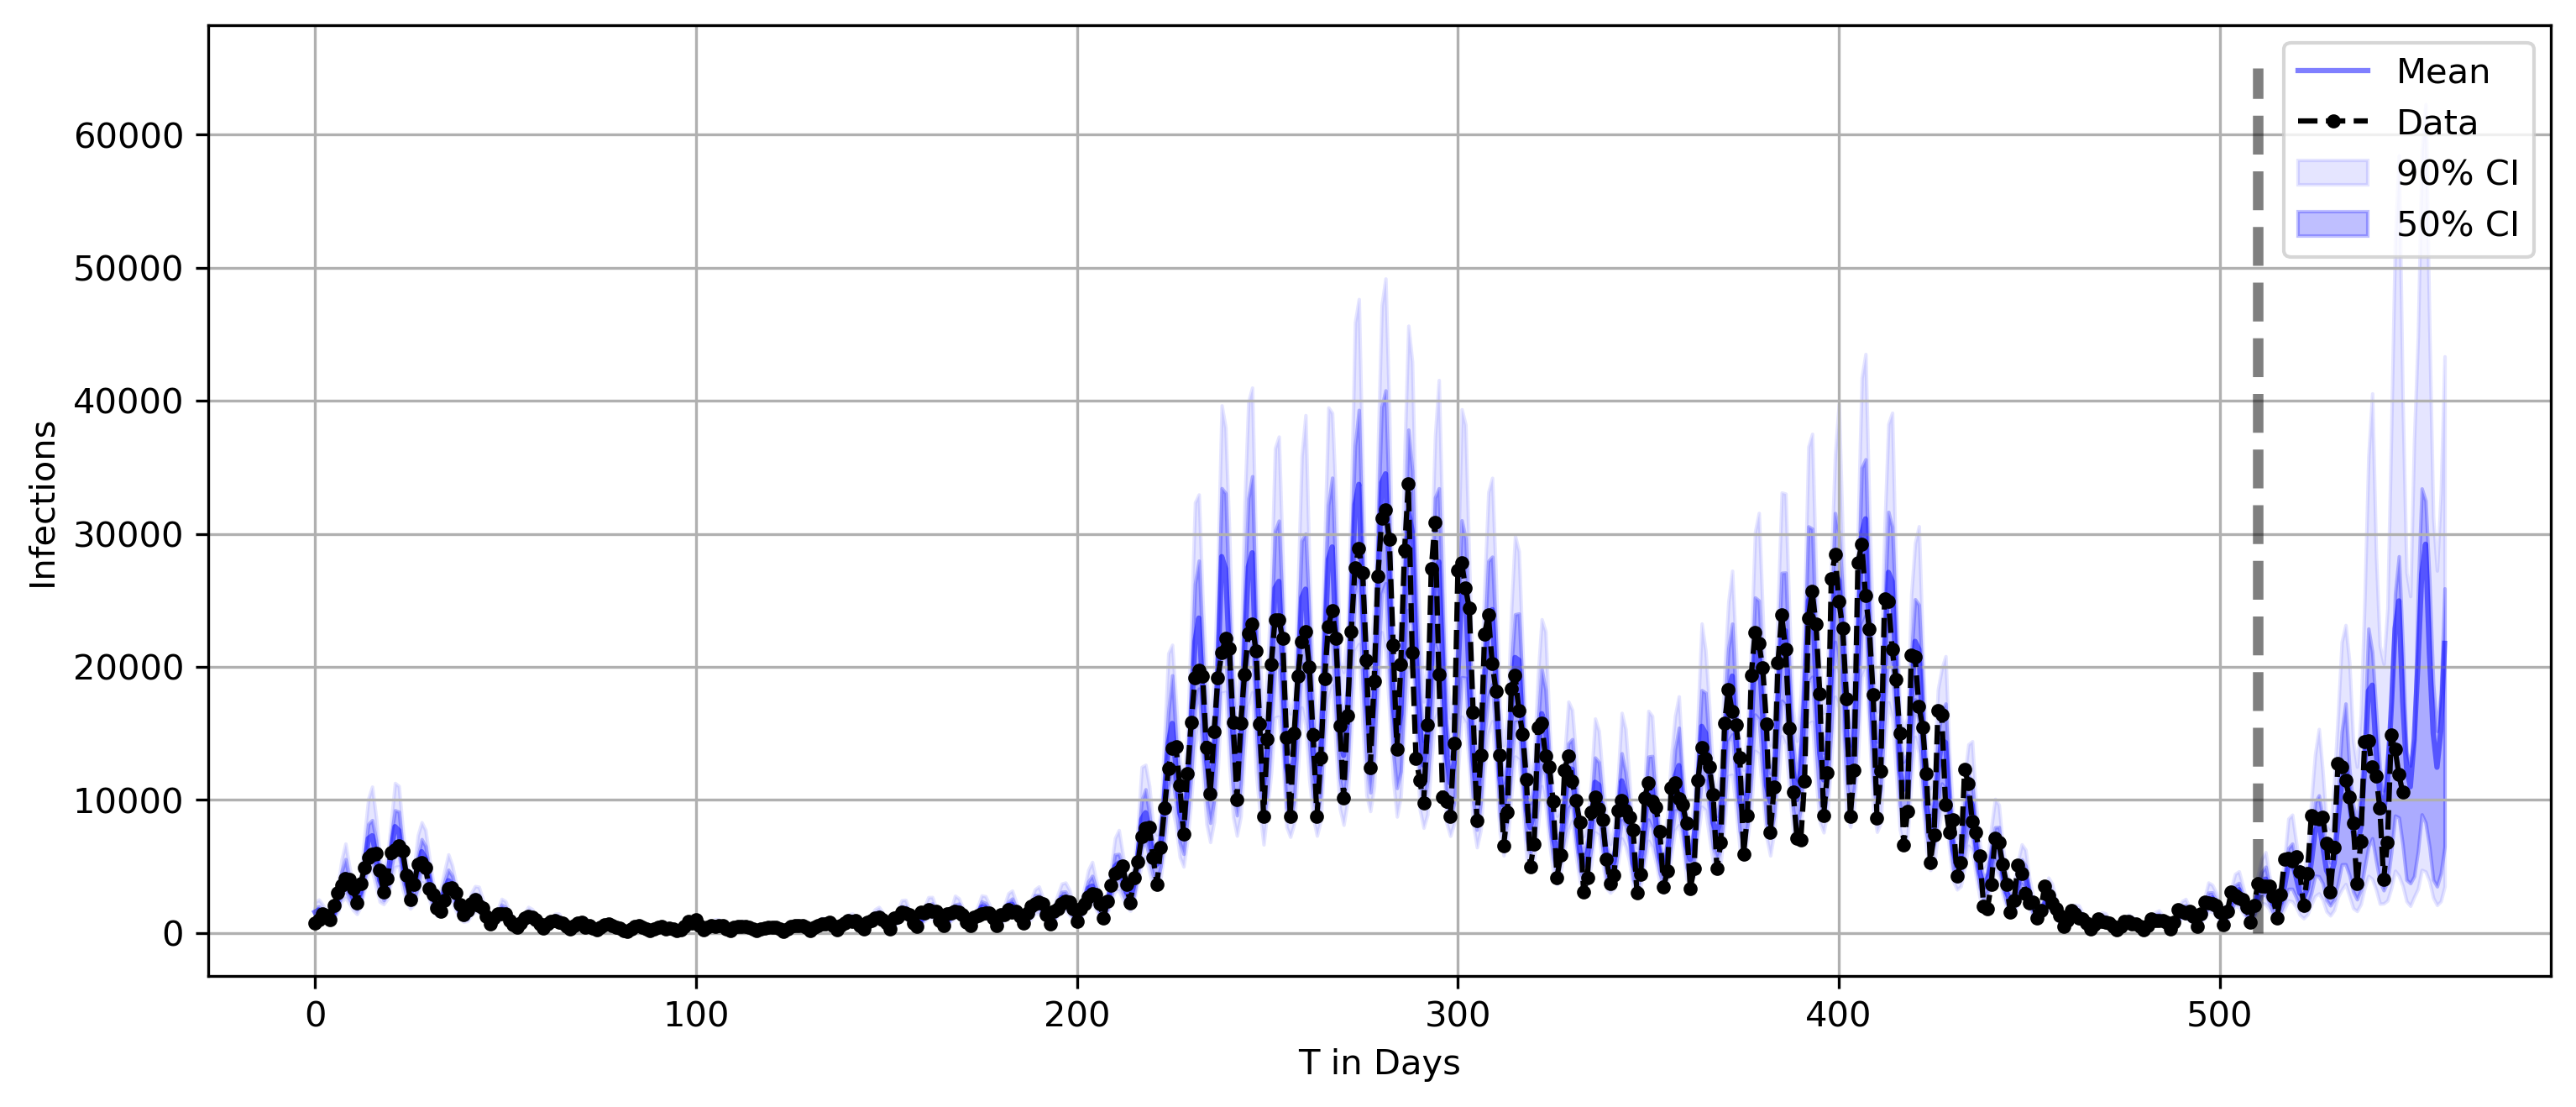

In [69]:
fig = plt.figure(figsize=(12,5), dpi=300)
plt.fill_between(np.arange(0, n_new), np.percentile(pred_samples['y_pred_new'], axis=0, q=[10]).ravel()[:],
                 np.percentile(pred_samples['y_pred_new'], axis=0, q=[90]).ravel()[:], alpha = 0.1, color='b', label='90% CI');
plt.fill_between(np.arange(0, n_new), np.percentile(pred_samples['y_pred_new'], axis=0, q=[25]).ravel()[:],
                 np.percentile(pred_samples['y_pred_new'], axis=0, q=[75]).ravel()[:], alpha = 0.25, color='b', label='50% CI');
plt.plot(np.arange(0, n_new), np.mean(pred_samples['y_pred_new'], axis=0)[:], color="blue", label='Mean', alpha=0.5)
plt.plot(np.arange(T-70),data_germany[70:,0], ".--", color="black", label="Data")
plt.legend()
plt.grid()
plt.vlines(510, 0, 65000, linewidth=3, color="black", alpha=0.5, linestyle="--")
plt.ylabel("Infections")
plt.xlabel("T in Days")
plt.savefig("gp_infections_all.png")